In [1]:
!git clone https://github.com/AdeelH/pytorch-fpn


Cloning into 'pytorch-fpn'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 220 (delta 26), reused 27 (delta 10), pack-reused 175
Receiving objects: 100% (220/220), 45.70 KiB | 1.27 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [1]:
%cd pytorch-fpn

/workspace/pytorch-fpn


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
!pip install pandas openpyxl matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 7.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 14.2 MB/s eta 0:00:00


In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image
import warnings
from fpn.factory import make_fpn_resnet
import torch.nn.functional as F

#torch.set_warn_always(True)
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#config=Dinov2Config(image_size=1800)
#model_di=Dinov2Model(config)

#model_di = Dinov2Model.from_pretrained("facebook/dinov2-large")

#model_di = AutoModel.from_pretrained('facebook/dinov2-large')
#process=AutoImageProcessor.from_pretrained("facebook/dinov2-large")




#model_h = ViTModel.from_pretrained("facebook/dinov2-base")
#model_h = model_h.to(device)
# Move the model to GPU if available
#input image
h=1000
w=1600
#output image from FPN
img_h=1000
img_w=1600

# Define the custom dataset
class ImageOneDDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.label_file = label_file
        self.transform = transform

        # Get the list of JPEG files in the root directory
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        # Load the labels and one-D data
        self.labels = pd.read_excel(label_file).values
        self.labels =  self.labels



    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
         # Get the image file name
        image_file = self.image_files[idx]

        # Read the image from the file
        image = Image.open(os.path.join(self.image_dir, image_file)).convert('RGB')

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Get the label and one-D data
        label =torch.tensor(self.labels).T[idx+1]/100



        # Return the image, label, and one-D data
        return image.float(), label.float()


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Define separate 2D CNNs for each channel
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Define Max Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Define MLP
        # The input features of the first linear layer will be calculated dynamically
        # based on the flattened size after the convolutions and pooling
        self.fc1 = nn.Linear(64 * (img_w//8) * (img_h//8) * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        # Separate channels
        channels = torch.chunk(x, chunks=3, dim=1)
        processed_channels = []

        for channel in channels:
            # Pass each channel through the CNN and Max Pool
            c = F.relu(self.conv1(channel))
            c = self.pool(c)
            c = F.relu(self.conv2(c))
            c = self.pool(c)
            c = F.relu(self.conv3(c))
            c = self.pool(c)

            # Flatten and reduce dimension
            # The flattening size is calculated dynamically based on the size of the tensor
            c = c.view(c.size(0), -1)  # Dynamic flattening
            processed_channels.append(c)

        # Concatenate the output of the 3 layers
        concatenated = torch.cat(processed_channels, dim=1)

        # Pass the concatenated tensor through the MLP

        x = F.relu(self.fc1(concatenated))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class FPN(nn.Module):

    def __init__(self, num_classes,img_h,img_w):

        super(FPN, self).__init__()
        self.img_h=img_h
        self.img_w=img_w
        self.num_classes=num_classes
        self.model = make_fpn_resnet(
          name='resnet50',
          fpn_type='fpn',
          pretrained=True,
          num_classes=self.num_classes,
          fpn_channels=256,
          in_channels=3,
          out_size=(self.img_h, self.img_w))
        self.CustomCNN=CustomCNN()


    def forward(self, x):

        x = self.model(x)
        x= self.CustomCNN(x)
        return x





# Create the dataset
#resize image

dataset = ImageOneDDataset(image_dir='/workspace/',
                          label_file='/workspace/try140_randomt.xlsx',
                          transform=transforms.Compose([
                              transforms.Resize((h, w)),
                              transforms.ToTensor(),

                          ]))
# Split the dataset into training, validation, and test sets
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Create the model
model = FPN(num_classes=3,img_h=img_h,img_w=img_w)
model = model.to(device)
#model= nn.DataParallel(model,device_ids=[0,1])


criterion = nn.MSELoss()

# Define the loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


import matplotlib.pyplot as plt

# Lists to store training and validation losses
train_loss_history = []
val_loss_history = []

# Train the model
for epoch in range(200):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Compute the loss
        loss = loss_fn(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



        if i % 100 == 0:
            # Record training loss
            train_loss_history.append(loss.item())
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item()}')

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # Move the inputs and targets to the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            val_loss += loss_fn(outputs, targets).item()

    # Calculate and record validation loss
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    print(f'Epoch: {epoch+1}, Validation Loss: {val_loss}')

# Plot the training and validation losses
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training and Validation Loss')
plt.legend()
plt.show()


# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/workspace/model.pt')

Epoch: 1, Batch: 1, Loss: 0.602867066860199
Epoch: 1, Validation Loss: 0.04218208184465766
Epoch: 2, Batch: 1, Loss: 0.006295086815953255
Epoch: 2, Validation Loss: 0.029412657022476196
Epoch: 3, Batch: 1, Loss: 0.008019289001822472
Epoch: 3, Validation Loss: 0.024118363624438643
Epoch: 4, Batch: 1, Loss: 0.00621586199849844
Epoch: 4, Validation Loss: 0.02491998579353094
Epoch: 5, Batch: 1, Loss: 0.03351800888776779
Epoch: 5, Validation Loss: 0.017709862207993865
Epoch: 6, Batch: 1, Loss: 0.01783137582242489
Epoch: 6, Validation Loss: 0.022847855929285288
Epoch: 7, Batch: 1, Loss: 0.019498705863952637
Epoch: 7, Validation Loss: 0.01875588670372963
Epoch: 8, Batch: 1, Loss: 0.013953800313174725
Epoch: 8, Validation Loss: 0.018690454540774226
Epoch: 9, Batch: 1, Loss: 0.0030542942695319653
Epoch: 9, Validation Loss: 0.01740296371281147
Epoch: 10, Batch: 1, Loss: 0.023153692483901978
Epoch: 10, Validation Loss: 0.01956140890251845
Epoch: 11, Batch: 1, Loss: 0.008753782138228416
Epoch: 11,

KeyboardInterrupt: 

In [11]:
torch.save(model.state_dict(), '/content/drive/MyDrive/workspace/model.pt')

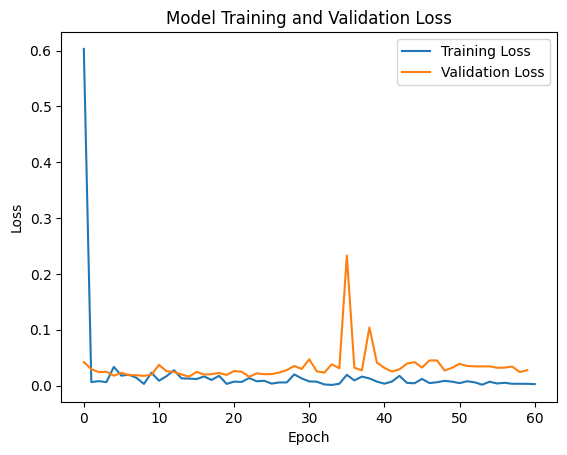

In [3]:
# Plot the training and validation losses
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training and Validation Loss')
plt.legend()
plt.show()

In [4]:
def mape(y_true, y_pred):
    # Avoid division by zero
    y_true = torch.clamp(y_true, min=1e-8)
    # Compute the absolute percentage error
    ape = torch.abs((y_true - y_pred) / y_true)*100
    # Return the mean over all predictions
    return torch.mean(ape)

with torch.no_grad():
    test_loss = 0.0
    test_mape = 0.0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        # Move the inputs and targets to the GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        print(targets)
        print(outputs)
        # Compute the loss
        test_loss += criterion(outputs, targets).item()
        # Compute the MAPE
        test_mape += mape(targets, outputs).item()
        print(test_mape)
    # Print the test loss and MAPE
    test_loss /= len(test_loader)
    test_mape /= len(test_loader)
    print(f'Test Loss: {test_loss}')
    print(f'Test MAPE: {test_mape}')

tensor([[1.0000, 0.9037, 0.6881, 0.2844, 0.0780, 0.0275],
        [1.0000, 0.9534, 0.8922, 0.7328, 0.2255, 0.0907]], device='cuda:0')
tensor([[0.9506, 0.9081, 0.8808, 0.6210, 0.2815, 0.1044],
        [0.9641, 0.9449, 0.8186, 0.5911, 0.2614, 0.0783]], device='cuda:0')
62.82402801513672
tensor([[1.0000, 0.9915, 0.9573, 0.5897, 0.1111, 0.0513],
        [1.0000, 0.8872, 0.8462, 0.7179, 0.2462, 0.0667]], device='cuda:0')
tensor([[0.9175, 0.8853, 0.7394, 0.4004, 0.2122, 0.0774],
        [0.9725, 0.8809, 0.6905, 0.3925, 0.1511, 0.1094]], device='cuda:0')
94.96304702758789
tensor([[1.0000, 1.0000, 0.9937, 0.8500, 0.1937, 0.0500],
        [1.0000, 0.9800, 0.8581, 0.3282, 0.0776, 0.0333]], device='cuda:0')
tensor([[0.9797, 0.9487, 0.8425, 0.5955, 0.2364, 0.0857],
        [0.9694, 0.9155, 0.7628, 0.4777, 0.1055, 0.0537]], device='cuda:0')
120.7655200958252
tensor([[1.0000, 1.0000, 0.9953, 0.6919, 0.1232, 0.0284]], device='cuda:0')
tensor([[0.9755, 0.9515, 0.8506, 0.5854, 0.2433, 0.0768]], device=